In [1]:
import tensorflow as tf
import keras
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import os
import datetime
import pandas as pd
from pathlib import Path
from numpy.typing import NDArray

tf.config.list_physical_devices('GPU')

2025-03-29 18:09:59.167220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743296999.185648   26456 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743296999.191313   26456 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-29 18:09:59.208920: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
data: NDArray = np.load("training_datasets.npy", allow_pickle=True)
labels: NDArray = np.load("training_labels.npy", allow_pickle=True)

In [3]:
data.shape, labels.shape

((34, 6, 4), (34, 6))

## Configuration values

In [4]:
baseline_config = {
    "name": "baseline",
    "LSTM_KWARGS": {
        "units": 32, 
        "dropout": 0.25, 
        "return_sequences": True
    },
    "CONV_KWARGS": [
        {"filters": 256, "kernel_size": 3, "strides": 1, "padding": "same", "data_format": "channels_last", "activation": "relu"},
        {"filters": 128, "kernel_size": 3, "strides": 1, "padding": "same", "data_format": "channels_last", "activation": "relu"},
        {"filters": 64, "kernel_size": 3, "strides": 1, "padding": "same", "data_format": "channels_last", "activation": "relu"}
    ],
    "CUSTOM_WEIGHTS": None,
    "WINDOW_SIZE_SEC": 5.0,
    "STRIDE_SEC": 1.0,
    "MAX_PREDICTED_LENGTH_SEC": 120.0,
    "OPTIMIZER": keras.optimizers.Adam
}

In [5]:
higher_window_config = copy.deepcopy(baseline_config)
higher_window_config["name"] = "higher_window"
higher_window_config["WINDOW_SIZE_SEC"] = 10.0

lower_window_config = copy.deepcopy(baseline_config)
lower_window_config["name"] = "lower_window"
lower_window_config["WINDOW_SIZE_SEC"] = 2.0

higher_stride_config = copy.deepcopy(baseline_config)
higher_stride_config["name"] = "higher_stride"
higher_stride_config["STRIDE_SEC"] = 2.5

lower_stride_config = copy.deepcopy(baseline_config)
lower_stride_config["name"] = "lower_stride"
lower_stride_config["STRIDE_SEC"] = 0.5

no_conv_config = copy.deepcopy(baseline_config)
no_conv_config["name"] = "no_conv"
no_conv_config["CONV_KWARGS"] = None

higher_lstm_units = copy.deepcopy(baseline_config)
higher_lstm_units["name"] = "higher_lstm_units"
higher_lstm_units["LSTM_KWARGS"]["units"] = 256

custom_weights_config = copy.deepcopy(baseline_config)
custom_weights_config["name"] = "custom_weights"
custom_weights_config["CUSTOM_WEIGHTS"] = {
    "EMG": 0.25,
    "HR": 0.25,
    "Accelerometer": 0.25,
    "Gyroscope": 0.25
}

no_emg_config = copy.deepcopy(baseline_config)
no_emg_config["name"] = "no_emg"
no_emg_config["CUSTOM_WEIGHTS"] = {
    "EMG": 0.0,
    "HR": 1/3,
    "Accelerometer": 1/3,
    "Gyroscope": 1/3
}

no_ppg_config = copy.deepcopy(baseline_config)
no_ppg_config["name"] = "no_ppg"
no_ppg_config["CUSTOM_WEIGHTS"] = {
    "EMG": 1/3,
    "HR": 0.0,
    "Accelerometer": 1/3,
    "Gyroscope": 1/3
}

no_accel_config = copy.deepcopy(baseline_config)
no_accel_config["name"] = "no_accel"
no_accel_config["CUSTOM_WEIGHTS"] = {
    "EMG": 1/3,
    "HR": 1/3,
    "Accelerometer": 0.0,
    "Gyroscope": 1/3
}

no_gyro_config = copy.deepcopy(baseline_config)
no_gyro_config["name"] = "no_gyro"
no_gyro_config["CUSTOM_WEIGHTS"] = {
    "EMG": 1/3,
    "HR": 1/3,
    "Accelerometer": 0.0,
    "Gyroscope": 1/3
}

In [6]:
model_configs = [
    # baseline_config,
    # higher_window_config,
    # lower_window_config,
    # higher_stride_config,
    lower_stride_config,
    # no_conv_config,
    # higher_lstm_units,
    # custom_weights_config,
    # no_emg_config,
    # no_ppg_config,
    # no_accel_config,
    # no_gyro_config
]

In [7]:
MASK_VALUE = 0.0
N_EPOCHS = 100

In [8]:
SAMPLING_RATE_EMG = 1. / 1000
SAMPLING_RATE_BPM = 1. / 200
SAMPLING_RATE_IMU = 1. / 100

(73750,) 73.75
(14749,) 73.745
(7375,) 73.75
(7375,) 73.75
(73000,) 73.0
(54660,) 54.660000000000004
(10931,) 54.655
(5466,) 54.660000000000004
(5466,) 54.660000000000004
(54000,) 54.0


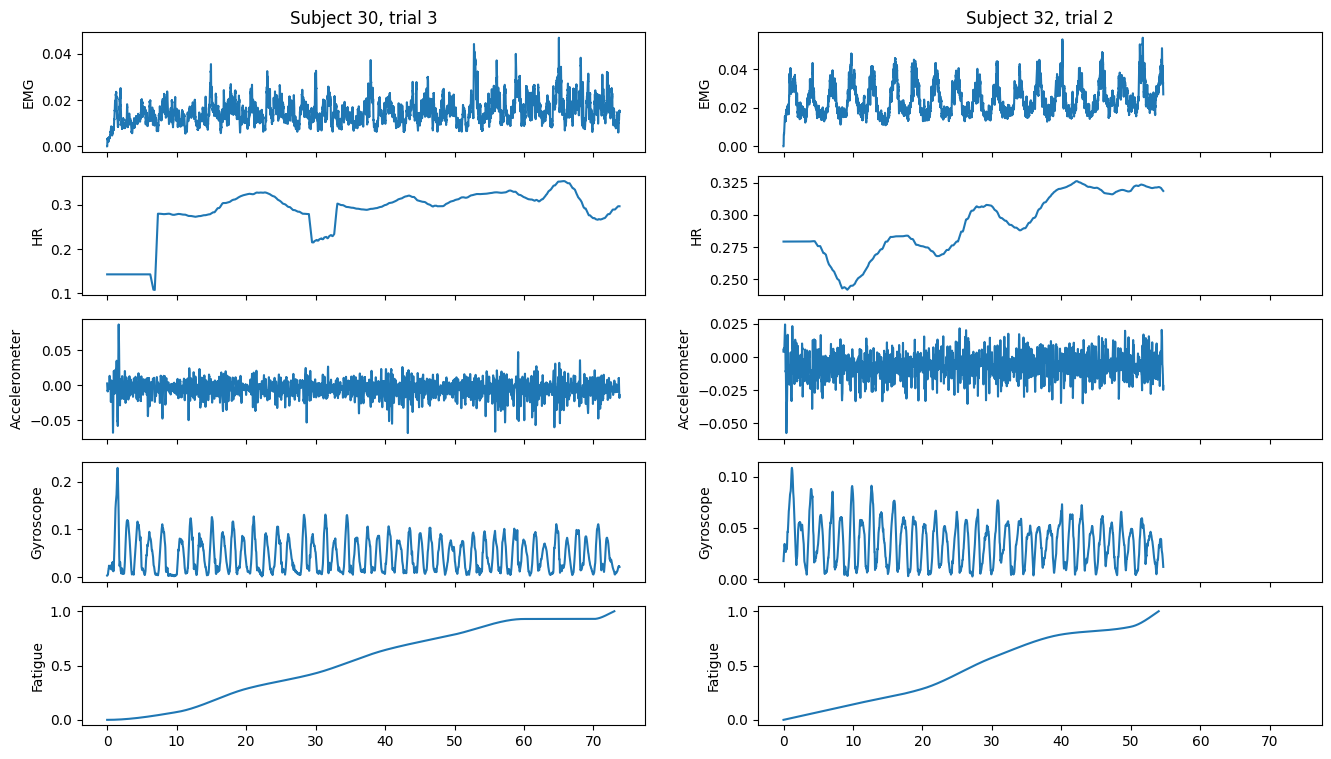

In [9]:
%matplotlib inline
signals = ("EMG", "HR", "Accelerometer", "Gyroscope", "Fatigue")
sampling_rates = (SAMPLING_RATE_EMG, SAMPLING_RATE_BPM, SAMPLING_RATE_IMU, SAMPLING_RATE_IMU, SAMPLING_RATE_EMG)

n_images = 2
fig, ax = plt.subplots(len(signals), n_images, sharex=True, figsize=(16,9))

for i in range(n_images):
    subject = np.random.randint(0, data.shape[0])
    trial = np.random.randint(0, data.shape[1])

    ax[0][i].set_title(f"Subject {subject}, trial {trial}")

    for j in range(len(signals)):
        if j == len(signals)-1:
            signal: NDArray = labels[subject][trial]
        else:
            signal: NDArray = data[subject][trial][j]

        print(signal.shape, sampling_rates[j]*signal.size)

        ax[j][i].plot(
            np.linspace(0.0, sampling_rates[j]*signal.size, signal.size), 
            signal
        )

        ax[j][i].set_ylabel(signals[j])

In [10]:
import os
import sys; sys.path.append(os.path.join(os.curdir, "src/fatigue_classifier/fatigue_classifier"))
from src.fatigue_classifier.fatigue_classifier.fatigue_model import FatigueClassifier, InputArgs
from src.fatigue_classifier.fatigue_classifier.fatigue_block import FatigueLSTMBlock

In [11]:
data.shape

(34, 6, 4)

In [12]:
combined_data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
combined_data.shape

(204, 4)

In [13]:
labels.shape

(34, 6)

In [14]:
combined_labels = labels.reshape((labels.shape[0]*labels.shape[1],))
combined_labels.shape

(204,)

In [15]:
def init_model(config: dict):
    lstm_blocks = []
    shapes = []

    inputs = {}
    input_shapes = []

    for i, Ts in enumerate(sampling_rates[:-1]):
        inputs[signals[i]], input_shape = FatigueClassifier.preprocess_signal(
            combined_data[..., i], 
            InputArgs(
                fs=1/Ts,
                window_size_sec=config["WINDOW_SIZE_SEC"], 
                stride_sec=config["STRIDE_SEC"], 
                max_duration_sec=config["MAX_PREDICTED_LENGTH_SEC"]
            ),
            pad_value=MASK_VALUE
        )
        input_shapes.append(input_shape)

    outputs = FatigueClassifier.preprocess_labels(
        combined_labels, 
        fs=1000, 
        window_size=config["WINDOW_SIZE_SEC"], 
        stride=config["STRIDE_SEC"], 
        max_duration_sec=config["MAX_PREDICTED_LENGTH_SEC"], 
        pad_value=MASK_VALUE
    )

    for k, v in inputs.items():
        if not config["CUSTOM_WEIGHTS"]: 
            weight = None
        elif k == "EMG": 
            weight = config["CUSTOM_WEIGHTS"]["EMG"]
        elif k == "HR": 
            weight = config["CUSTOM_WEIGHTS"]["HR"]
        elif k == "Accelerometer": 
            weight = config["CUSTOM_WEIGHTS"]["Accelerometer"]
        elif k == "Gyroscope": 
            weight = config["CUSTOM_WEIGHTS"]["Gyroscope"]
        else: 
            raise NotImplementedError(f"Invalid key: {k}")

        lstm_block = FatigueLSTMBlock(
            weight=weight, 
            mask=MASK_VALUE, 
            lstm_kwargs=config["LSTM_KWARGS"], 
            conv_layers_kwargs=config["CONV_KWARGS"],
            name=k.lower()
        )

        lstm_blocks.append(lstm_block)

        # Insert "None" as the first element to represent the batch size 
        shapes.append(tuple([None] + list(v.shape[1:])))

    print(input_shapes)
    fatigue_classifier = FatigueClassifier(lstm_blocks=lstm_blocks, input_shapes=input_shapes)
    fatigue_classifier.build(shapes)
    print(fatigue_classifier.summary(expand_nested=True))

    # TODO(george): make this safe?
    # Can just pass MASK_VALUE in lambda? Below doesn't work - likely needs to be partial.
    # keras.config.enable_unsafe_deserialization()
    # fatigue_classifier.compile(optimizer=baseline_config["OPTIMIZER"](), loss=lambda y_true, y_pred: FatigueClassifier.loss(y_true, y_pred, MASK_VALUE))
    
    fatigue_classifier.compile(optimizer=baseline_config["OPTIMIZER"](), loss=FatigueClassifier.loss)

    return fatigue_classifier, inputs, outputs

Input shape: $ (N_B, N_T, N_S) $

Where

$N_B = $ batch size,

$N_T = $ timesteps,

$N_S = $ samples

Output shape: $ (N_B, N_T) $

Where

$N_B = $ batch size

$N_T = $ timesteps

In [16]:
VALIDATION_SPLIT = 0.8

In [17]:
%matplotlib inline
def plot_images(output_path: Path, model: FatigueClassifier, config: dict, training_dataset: tf.data.Dataset, validation_dataset: tf.data.Dataset, source_signals: NDArray, source_labels: NDArray):
    os.makedirs(os.path.join(output_path, "train"), exist_ok=True)
    os.makedirs(os.path.join(output_path, "validation"), exist_ok=True)

    signals = ("EMG", "HR", "Accelerometer", "Gyroscope", "Fatigue")
    sampling_rates = (SAMPLING_RATE_EMG, SAMPLING_RATE_BPM, SAMPLING_RATE_IMU, SAMPLING_RATE_IMU, SAMPLING_RATE_EMG)

    train_losses = []
    validation_losses = []

    for is_training, dataset in zip([True, False], [training_dataset, validation_dataset]):
        offset = 0 if is_training else int(VALIDATION_SPLIT * source_signals.shape[0])
        for i, (inputs, outputs) in enumerate(dataset.as_numpy_iterator()):
            fig, ax = plt.subplots(len(signals), 1, sharex=True, figsize=(16,9))
            fig.suptitle(f"{'Training' if is_training else 'Validation'} dataset (index={i})")

            for j,name in enumerate(signals):
                a: Axes = ax[j]
            
                if name != "Fatigue":
                    signal: NDArray = source_signals[i+offset][j]
                else:
                    signal: NDArray = source_labels[i+offset]

                signal=signal[np.where(signal != MASK_VALUE)]

                a.plot(
                    np.linspace(0.0, sampling_rates[j]*signal.size, signal.size), 
                    signal
                )

                a.set_ylabel(signals[j])

                if name == "Fatigue":
                    out = model.predict(
                        inputs,
                        batch_size=1
                    )

                    out_pred = copy.deepcopy(out[0, :, 0])
                    out_pred=out_pred[np.where(outputs[0] != MASK_VALUE)[0]]

                    a.scatter(
                        np.arange(config["WINDOW_SIZE_SEC"], config["WINDOW_SIZE_SEC"]+out_pred.size*config["STRIDE_SEC"], config["STRIDE_SEC"]), 
                        out_pred,
                        c="red"
                    )

                    a.scatter(
                        np.arange(config["WINDOW_SIZE_SEC"], config["WINDOW_SIZE_SEC"]+out_pred.size*config["STRIDE_SEC"], config["STRIDE_SEC"]), 
                        outputs[0][np.where(outputs[0] != MASK_VALUE)[0]],
                        c="green"
                    )

                    loss = FatigueClassifier.loss(np.reshape(outputs, (1, outputs.size, 1)), out, MASK_VALUE)
                    if is_training: train_losses.append(loss.numpy())
                    else: validation_losses.append(loss.numpy())
                    a.text(0.0, 0.8, f"MSE: {loss:.4f}", 
                        fontsize=12, ha='left', va='center', bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.5'))

            fig.savefig(os.path.join(output_path, "train" if is_training else "validation", f"{'train' if is_training else 'validation'}_{i}.png"))
            plt.close()


    return train_losses, validation_losses

In [18]:
np.random.seed(42)
N_EPOCHS = 1
for config in model_configs:
    output_path = f"fatigue_ml_outputs_{config['name']}_{datetime.datetime.now().isoformat()}"
    os.makedirs(os.path.join(output_path, "train"))
    os.makedirs(os.path.join(output_path, "validation"))

    try:
        fatigue_classifier, inputs, outputs = init_model(config)
        
        N_SAMPLES = inputs["EMG"].shape[0]

        indices = np.arange(N_SAMPLES)
        np.random.shuffle(indices)
        
        full_dataset: tf.data.Dataset = tf.data.Dataset.from_tensor_slices(
            (
                (
                    tf.convert_to_tensor(inputs["EMG"][indices], dtype="float32"), 
                    tf.convert_to_tensor(inputs["HR"][indices], dtype="float32"), 
                    tf.convert_to_tensor(inputs["Accelerometer"][indices], dtype="float32"), 
                    tf.convert_to_tensor(inputs["Gyroscope"][indices], dtype="float32")
                ), 
                tf.convert_to_tensor(outputs[indices], dtype="float32")
            ) 
        )

        train_dataset = full_dataset.take(int(VALIDATION_SPLIT * N_SAMPLES))
        validation_dataset = full_dataset.skip(int(VALIDATION_SPLIT * N_SAMPLES))

        history = fatigue_classifier.fit(
            train_dataset.batch(5), 
            epochs=N_EPOCHS,
            validation_data=validation_dataset.batch(5)
        )

        # Save model
        _path = "fatigue_model.keras"
        fatigue_classifier.save(_path)

        break

        # Plot history
        # fig = plt.figure()
        # ax = fig.add_subplot(111)
        # ax.plot(history.history["loss"])
        # ax.plot(history.history["val_loss"])
        # ax.set_axisbelow(True)
        # fig.savefig(os.path.join(output_path, "loss.png"))
        # plt.close()

        # # Save history
        # df = pd.DataFrame()
        # df["loss"] = history.history["loss"]
        # df["val_loss"] = history.history["val_loss"]
        # df.to_csv(os.path.join(output_path, "losses_by_epoch.csv"))

        # train_losses, validation_losses = plot_images(
        #     output_path,
        #     fatigue_classifier, 
        #     config, 
        #     train_dataset.batch(1), 
        #     validation_dataset.batch(1),
        #     source_signals=combined_data[indices],
        #     source_labels=combined_labels[indices]
        # )

        # df = pd.DataFrame()
        # df["loss"] = train_losses
        # df.to_csv(os.path.join(output_path, "training_losses_by_trial.csv"))

        # df = pd.DataFrame()
        # df["loss"] = validation_losses
        # df.to_csv(os.path.join(output_path, "validation_losses_by_trial.csv"))
    except Exception as e:
        print(f"Model {config['name']} failed")
        import traceback; traceback.print_exception(e)

{'fs': 1000.0, 'window_size_sec': 5.0, 'stride_sec': 0.5, 'max_duration_sec': 120.0}
{'fs': 200.0, 'window_size_sec': 5.0, 'stride_sec': 0.5, 'max_duration_sec': 120.0}
{'fs': 100.0, 'window_size_sec': 5.0, 'stride_sec': 0.5, 'max_duration_sec': 120.0}
{'fs': 100.0, 'window_size_sec': 5.0, 'stride_sec': 0.5, 'max_duration_sec': 120.0}


I0000 00:00:1743297005.380144   26456 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5070 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:02:00.0, compute capability: 6.1


[{'fs': 1000.0, 'max_duration_sec': 120.0, 'size': 120000, 'window': 5000, 'stride': 500, 'shape': (230, 5000)}, {'fs': 200.0, 'max_duration_sec': 120.0, 'size': 24000, 'window': 1000, 'stride': 100, 'shape': (230, 1000)}, {'fs': 100.0, 'max_duration_sec': 120.0, 'size': 12000, 'window': 500, 'stride': 50, 'shape': (230, 500)}, {'fs': 100.0, 'max_duration_sec': 120.0, 'size': 12000, 'window': 500, 'stride': 50, 'shape': (230, 500)}]


Model: "fatigue_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ emg (FatigueLSTMBlock)          │ (None, 230, 1)         │     3,975,777 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1d (Conv1D)            │ (None, 230, 256)       │     3,840,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1d_1 (Conv1D)          │ (None, 230, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1d_2 (Conv1D)          │ (None, 230, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ masking (Masking)          │ (None, 230, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ lstm (LSTM)                │ (None, 230, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense (Dense)              │ (None, 230, 1)         │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hr (FatigueLSTMBlock)           │ (None, 230, 1)         │       903,777 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1d_3 (Conv1D)          │ (None, 230, 256)       │       768,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1d_4 (Conv1D)          │ (None, 230, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1d_5 (Conv1D)          │ (None, 230, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ masking_1 (Masking)        │ (None, 230, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ lstm_1 (LSTM)              │ (None, 230, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_1 (Dense)            │ (None, 230, 1)         │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ accelerometer                   │ (None, 230, 1)         │       519,777 │
│ (FatigueLSTMBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1d_6 (Conv1D)          │ (None, 230, 256)       │       384,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1d_7 (Conv1D)          │ (None, 230, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1d_8 (Conv1D)          │ (None, 230, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ masking_2 (Masking)        │ (None, 230, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ lstm_2 (LSTM)              │ (None, 230, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dense_2 (Dense)            │ (None, 230, 1)         │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gyroscope (FatigueLSTMBlock)    │ (None, 230, 1)         │       519,777 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1d_9 (Conv1D)          │ (None, 230, 256)       │       384,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ conv1d_10 (Conv1D)         │ (None, 230, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,919,113 (22.58 MB)

 Trainable params: 5,919,113 (22.58 MB)

 Non-trainable params: 0 (0.00 B)

None


I0000 00:00:1743297017.722469   26528 cuda_dnn.cc:529] Loaded cuDNN version 90300


33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: 0.0696 - val_loss: 0.0580


2025-03-29 18:10:23.512608: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


In [19]:
new_model = FatigueClassifier.from_file(_path)

In [21]:
new_model.get_input_shape("accel")

(2,
 {'fs': 100.0,
  'max_duration_sec': 120.0,
  'size': 12000,
  'window': 500,
  'stride': 50,
  'shape': [230, 500]})